Block 1: Import các thư viện cần thiết

In [20]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

Block 2: Đọc và chuẩn bị dữ liệu

In [21]:
# Đọc dữ liệu
df = pd.read_csv('Gold Futures Historical Data.csv')

# Thêm ID cho dữ liệu
df1 = df
df1['unique_id'] = 'GOLD'

# Sắp xếp lại các cột
df1 = df1[['unique_id', 'Date', 'Price']]

# Đổi tên các cột để phù hợp với định dạng của thư viện
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)

# Hiển thị thông tin dữ liệu
print("Thông tin dữ liệu ban đầu:")
print(df1.head())

Thông tin dữ liệu ban đầu:
  unique_id          ds         y
0      GOLD  01/03/2025  2,654.70
1      GOLD  01/02/2025  2,669.00
2      GOLD  12/31/2024  2,641.00
3      GOLD  12/30/2024  2,618.10
4      GOLD  12/27/2024  2,618.40


C:\Users\quyen\AppData\Local\Temp\ipykernel_7036\2528335541.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)


Block 3: Chuyển đổi kiểu dữ liệu và sắp xếp

In [22]:
# Chuyển đổi kiểu dữ liệu
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].str.replace(',', '').astype(float)  # Xử lý dấu phẩy trong dữ liệu giá

# Đảo ngược dữ liệu để có thứ tự tăng dần theo thời gian (từ cũ đến mới)
df1 = df1.sort_values('ds')

# Hiển thị thông tin dữ liệu sau khi chuyển đổi
print("\nThông tin dữ liệu sau khi chuyển đổi:")
df1.info()


Thông tin dữ liệu sau khi chuyển đổi:
<class 'pandas.core.frame.DataFrame'>
Index: 774 entries, 773 to 0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  774 non-null    object        
 1   ds         774 non-null    datetime64[ns]
 2   y          774 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 24.2+ KB


C:\Users\quyen\AppData\Local\Temp\ipykernel_7036\3864518307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ds'] = pd.to_datetime(df1['ds'])
C:\Users\quyen\AppData\Local\Temp\ipykernel_7036\3864518307.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['y'] = df1['y'].str.replace(',', '').astype(float)  # Xử lý dấu phẩy trong dữ liệu giá


Block 4: Chia dữ liệu theo tỷ lệ 7:3

In [23]:
# Kích thước dữ liệu
size = len(df1)

# Chia dữ liệu theo tỷ lệ 7:3
train_data = df1[:int(0.7 * size)]
test_data = df1[int(0.7 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("\nĐộ dài tập huấn luyện:", train_len)
print("Độ dài tập kiểm tra:", test_len)

# Thông tin giá trị lớn nhất trong tập huấn luyện
print("\nGiá trị lớn nhất trong tập huấn luyện:")
print(train_data.max())


Độ dài tập huấn luyện: 541
Độ dài tập kiểm tra: 233

Giá trị lớn nhất trong tập huấn luyện:
unique_id                   GOLD
ds           2024-02-06 00:00:00
y                         2083.5
dtype: object


Block 5: Cấu hình và khởi tạo mô hình

In [24]:
# Cấu hình mô hình FEDformer
model = FEDformer(
    h=test_len + 90,  # Dự đoán cho tập test và thêm 90 ngày
    input_size=120,    # Sử dụng 120 ngày làm đầu vào
    modes=64,          # Giảm modes để giảm độ phức tạp
    hidden_size=128,   # Tăng kích thước hidden layer
    n_head=8,          # Số lượng heads phải là 8
    loss=MAE(),        # Sử dụng hàm mất mát MAE
    scaler_type='standard',  # Loại scaler
    learning_rate=1e-3,      # Tốc độ học
    max_steps=100,           # Số bước huấn luyện tối đa
    batch_size=32,           # Kích thước batch
    windows_batch_size=256,  # Kích thước cửa sổ batch
)

# Khởi tạo NeuralForecast với mô hình FEDformer
nf = NeuralForecast(
    models=[model],
    freq='D',  # Tần suất dữ liệu theo ngày
)

Seed set to 1


Block 5: Huấn luyện mô hình và thực hiện dự đoán

In [25]:
# Huấn luyện mô hình
print("\nBắt đầu huấn luyện mô hình:")
nf.fit(df=train_data, static_df=None, verbose=True)

# Dự đoán
print("\nThực hiện dự đoán:")
forecasts = nf.predict()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 271 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
675 K     Trainable params
0         Non-trainable params
675 K     Total params
2.702     Total estimated model params size (MB)
80        Modules in train mode
0         Modules in eval mode



Bắt đầu huấn luyện mô hình:


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Thực hiện dự đoán:


Predicting: |          | 0/? [00:00<?, ?it/s]

Block 7: Chuẩn bị dữ liệu dự đoán

In [26]:
# Chuẩn bị dữ liệu để đánh giá
train = train_data['y'].reset_index(drop=True)
test = test_data['y'].reset_index(drop=True)

# Chuyển đổi forecasts để có thể truy cập với index
predict = forecasts['FEDformer'].reset_index(drop=True)

# Tách dự đoán cho tập kiểm tra và tương lai
predict_test = predict[:test_len]
predict_future = predict[test_len:]

# Chia dự đoán tương lai thành 3 giai đoạn: 30, 60, 90 ngày
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

Block 8: In kết quả dự đoán

In [27]:
# In kết quả dự đoán
print("\nDự đoán giá vàng cho 30 ngày tới:")
print(predict_future_30)

print("\nDự đoán giá vàng cho 60 ngày tới:")
print(predict_future_60)

print("\nDự đoán giá vàng cho 90 ngày tới:")
print(predict_future_90)


Dự đoán giá vàng cho 30 ngày tới:
233    2195.833252
234    2199.541504
235    2197.767334
236    2205.437256
237    2219.225342
238    2210.856445
239    2209.832520
240    2227.410645
241    2231.717773
242    2233.831787
243    2237.404541
244    2247.725342
245    2248.959961
246    2259.948730
247    2229.642334
248    2253.061768
249    2231.612061
250    2220.082275
251    2231.948242
252    2236.954102
253    2233.381348
254    2238.648438
255    2244.559326
256    2258.741211
257    2256.723145
258    2255.684814
259    2260.465088
260    2260.459961
261    2272.193848
262    2269.261475
Name: FEDformer, dtype: float32

Dự đoán giá vàng cho 60 ngày tới:
263    2278.237793
264    2275.012695
265    2276.245117
266    2284.347412
267    2273.942139
268    2276.490967
269    2252.105225
270    2262.449707
271    2237.245117
272    2228.132080
273    2245.496826
274    2244.695312
275    2250.036133
276    2247.183105
277    2234.036133
278    2240.695312
279    2233.697754
280  

Block 9: Đánh giá hiệu suất mô hình

In [28]:
# Đánh giá hiệu suất mô hình trên tập kiểm tra
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("\nKết quả đánh giá mô hình:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)


Kết quả đánh giá mô hình:
Mean Absolute Error (MAE): 309.78782775616946
Mean Absolute Percentage Error (MAPE): 0.12302041550394852
Mean Square Error (MSE): 118151.55420866865
Root Mean Square Error (RMSE): 343.7318056401948


Block 10: Chuẩn bị dữ liệu để vẽ biểu đồ với trục thời gian

In [29]:
# Chuẩn bị dữ liệu cho việc vẽ biểu đồ với trục thời gian
# Lấy tất cả các ngày từ tập huấn luyện và kiểm tra
train_dates = train_data['ds'].reset_index(drop=True)
test_dates = test_data['ds'].reset_index(drop=True)

# Tạo 90 ngày tương lai cho dự đoán
last_date = test_dates.iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='D')

# Tạo DataFrame cho dữ liệu dự đoán và ngày tương ứng
train_df = pd.DataFrame({'ds': train_dates, 'y': train})
test_df = pd.DataFrame({'ds': test_dates, 'y': test, 'pred': predict_test})

# DataFrame cho dự đoán tương lai
future_30_df = pd.DataFrame({'ds': future_dates[:30], 'pred': predict_future_30})
future_60_df = pd.DataFrame({'ds': future_dates[30:60], 'pred': predict_future_60})
future_90_df = pd.DataFrame({'ds': future_dates[60:90], 'pred': predict_future_90})

Block 11: Vẽ biểu đồ ban đầu với trục thời gian

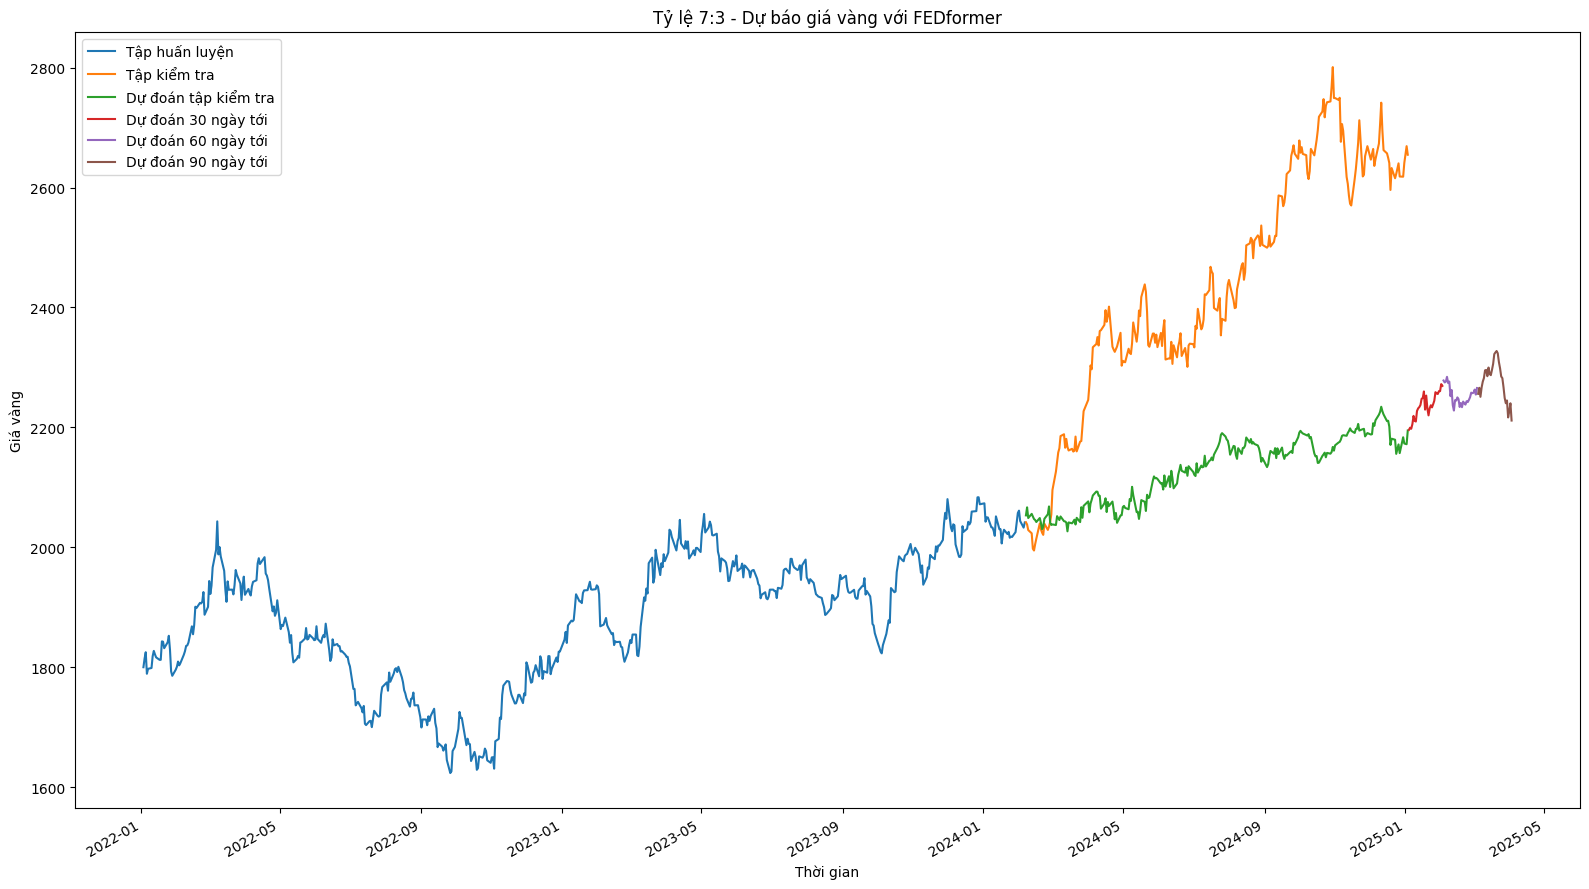

In [30]:
# Vẽ biểu đồ với trục thời gian
plt.figure(figsize=(16, 9))

# Vẽ dữ liệu huấn luyện
plt.plot(train_df['ds'], train_df['y'], label='Tập huấn luyện')

# Vẽ dữ liệu kiểm tra và dự đoán
plt.plot(test_df['ds'], test_df['y'], label='Tập kiểm tra')
plt.plot(test_df['ds'], test_df['pred'], label='Dự đoán tập kiểm tra')

# Vẽ dự đoán tương lai
plt.plot(future_30_df['ds'], future_30_df['pred'], label='Dự đoán 30 ngày tới')
plt.plot(future_60_df['ds'], future_60_df['pred'], label='Dự đoán 60 ngày tới')
plt.plot(future_90_df['ds'], future_90_df['pred'], label='Dự đoán 90 ngày tới')

# Tùy chỉnh biểu đồ
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.title('Tỷ lệ 7:3 - Dự báo giá vàng với FEDformer')
plt.legend()

# Định dạng trục thời gian
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

Block 12: Áp dụng bộ lọc Savitzky-Golay

In [31]:
# Áp dụng bộ lọc Savitzky-Golay để làm mượt dự đoán
print("\nÁp dụng bộ lọc Savitzky-Golay để làm mượt dự đoán")

# Tạo mảng NumPy từ dự đoán để áp dụng bộ lọc
predict_array = predict.to_numpy()
predict_smoothed = savgol_filter(predict_array, window_length=31, polyorder=3)

# Chia dự đoán đã làm mượt
predict_test_smoothed = predict_smoothed[:test_len]
predict_future_smoothed = predict_smoothed[test_len:]

# Chia dự đoán tương lai đã làm mượt
predict_future_30_smoothed = predict_future_smoothed[:30]
predict_future_60_smoothed = predict_future_smoothed[30:60]
predict_future_90_smoothed = predict_future_smoothed[60:]


Áp dụng bộ lọc Savitzky-Golay để làm mượt dự đoán


Block 13: In kết quả dự đoán đã làm mượt

In [32]:
# In kết quả dự đoán đã làm mượt
print("\nDự đoán đã làm mượt cho 30 ngày tới:")
print(predict_future_30_smoothed)

print("\nDự đoán đã làm mượt cho 60 ngày tới:")
print(predict_future_60_smoothed)

print("\nDự đoán đã làm mượt cho 90 ngày tới:")
print(predict_future_90_smoothed)


Dự đoán đã làm mượt cho 30 ngày tới:
[2188.272  2193.4138 2199.4185 2204.7332 2210.291  2215.924  2219.8472
 2223.8896 2227.2175 2229.3745 2232.044  2233.4153 2235.7546 2236.825
 2237.6704 2239.0088 2240.509  2242.0293 2242.976  2244.6572 2246.7754
 2249.3777 2250.9    2253.9495 2256.9836 2258.7192 2260.2783 2261.8274
 2263.431  2266.0408]

Dự đoán đã làm mượt cho 60 ngày tới:
[2266.4941 2268.017  2267.6707 2266.322  2265.0134 2263.1858 2260.8083
 2258.078  2255.1372 2252.476  2249.8765 2247.2717 2244.8047 2242.9153
 2241.3538 2240.4968 2240.0273 2240.5906 2240.9302 2241.9343 2243.0007
 2244.4985 2245.63   2248.4036 2249.7588 2251.4082 2254.123  2256.626
 2259.299  2261.5918]

Dự đoán đã làm mượt cho 90 ngày tới:
[2263.6138 2266.2532 2269.0396 2273.0894 2277.377  2281.8188 2286.116
 2290.373  2294.71   2298.575  2301.5386 2304.6704 2306.061  2306.0579
 2305.925  2305.2622 2303.84   2301.6223 2298.572  2294.6528 2289.8281
 2284.0613 2277.316  2269.5554 2260.743  2250.842  2239.8164 222

Block 14: Đánh giá hiệu suất mô hình sau khi làm mượt

In [33]:
# Đánh giá lại hiệu suất mô hình với dự đoán đã làm mượt
mae = mean_absolute_error(test, predict_test_smoothed)
mape = mean_absolute_percentage_error(test, predict_test_smoothed)
mse = mean_squared_error(test, predict_test_smoothed)
rmse = np.sqrt(mean_squared_error(test, predict_test_smoothed))

print("\nKết quả đánh giá mô hình sau khi làm mượt:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)


Kết quả đánh giá mô hình sau khi làm mượt:
Mean Absolute Error (MAE): 309.55192252883575
Mean Absolute Percentage Error (MAPE): 0.12291712701196023
Mean Square Error (MSE): 117919.89233659893
Root Mean Square Error (RMSE): 343.3946597380322


Block 15: Chuẩn bị dữ liệu và vẽ biểu đồ sau khi làm mượt

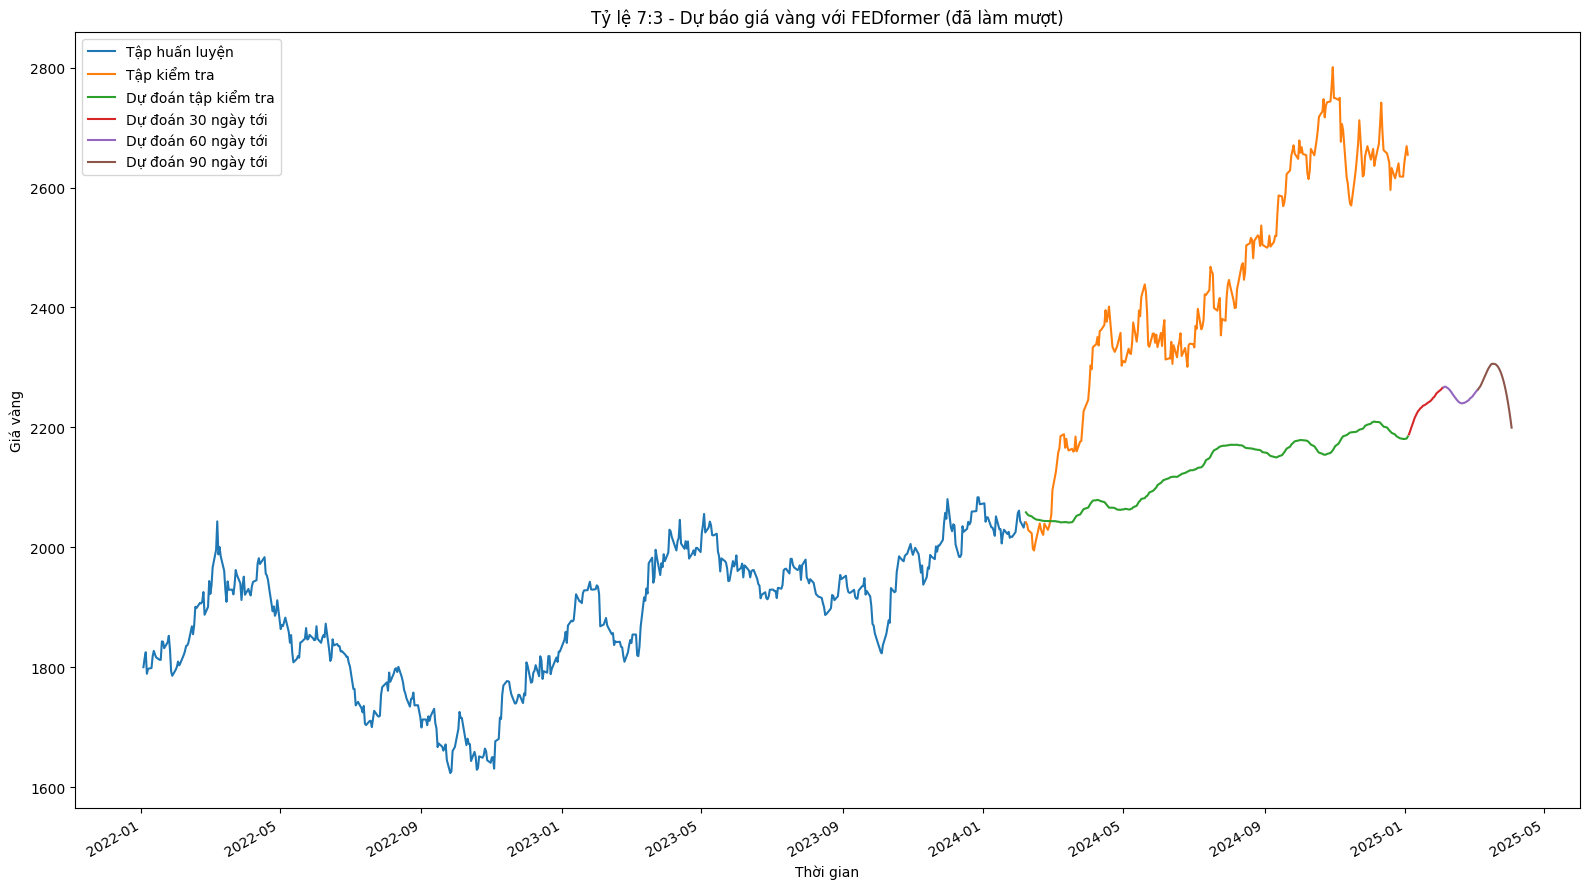

In [34]:
# Chuẩn bị DataFrame cho dữ liệu đã làm mượt
test_smoothed_df = pd.DataFrame({'ds': test_dates, 'y': test, 'pred': predict_test_smoothed})
future_30_smoothed_df = pd.DataFrame({'ds': future_dates[:30], 'pred': predict_future_30_smoothed})
future_60_smoothed_df = pd.DataFrame({'ds': future_dates[30:60], 'pred': predict_future_60_smoothed})
future_90_smoothed_df = pd.DataFrame({'ds': future_dates[60:90], 'pred': predict_future_90_smoothed})

# Vẽ biểu đồ kết quả sau khi làm mượt
plt.figure(figsize=(16, 9))

# Vẽ dữ liệu huấn luyện
plt.plot(train_df['ds'], train_df['y'], label='Tập huấn luyện')

# Vẽ dữ liệu kiểm tra và dự đoán đã làm mượt
plt.plot(test_smoothed_df['ds'], test_smoothed_df['y'], label='Tập kiểm tra')
plt.plot(test_smoothed_df['ds'], test_smoothed_df['pred'], label='Dự đoán tập kiểm tra')

# Vẽ dự đoán tương lai đã làm mượt
plt.plot(future_30_smoothed_df['ds'], future_30_smoothed_df['pred'], label='Dự đoán 30 ngày tới')
plt.plot(future_60_smoothed_df['ds'], future_60_smoothed_df['pred'], label='Dự đoán 60 ngày tới')
plt.plot(future_90_smoothed_df['ds'], future_90_smoothed_df['pred'], label='Dự đoán 90 ngày tới')

# Tùy chỉnh biểu đồ
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng')
plt.title('Tỷ lệ 7:3 - Dự báo giá vàng với FEDformer (đã làm mượt)')
plt.legend()

# Định dạng trục thời gian
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()